# AI4D Research Lab Tanzania Tourism Prediction
# By Mohamed Eltayeb

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import  LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

In [2]:
#Plot the LGBM Features Importances
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

# Read the training and testing data


In [122]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
ID = test_df['Tour_ID']

# Features:

In [ ]:
Features_Definitions = pd.read_csv("VariableDefinitions.csv")
Features_Definitions

## Fix Some Typos in the Data

In [123]:
for dataset in (train_df,test_df):
    for i in range(0,dataset.shape[0]):
        if(dataset['main_activity'][i] == 'Widlife Tourism'):
            dataset['main_activity'][i] = 'Wildlife Tourism'
        if(dataset['country'][i] == 'SWIZERLAND'):
            dataset['country'][i] = 'SWITZERLAND'
        if(dataset['country'][i] == 'MORROCO'):
            dataset['country'][i] = 'MOROCCO'
        if(dataset['country'][i] == 'MALT'):
            dataset['country'][i] = 'MALTA'
        if(dataset['country'][i] == 'COSTARICA'):
            dataset['country'][i] = 'COSTA RICA'

# Exploratory Data Analysis:

In [ ]:
train_df.shape

In [ ]:
test_df.shape

In [ ]:
train_df.info()

In [ ]:
test_df.info()

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

In [ ]:
#The cardinality of each catgorical feature (Training)
cat_cols = train_df.columns
for col in cat_cols:
    print(col, train_df[col].nunique())

In [ ]:
#The cardinality of each catgorical feature (Testing)
cat_cols = test_df.columns
for col in cat_cols:
    print(col, test_df[col].nunique())

# Plots

In [ ]:
#Target Histogram
train_df['cost_category'].hist()

In [ ]:
#Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

In [ ]:
#Numerical Features Histograms (Test)
num_feats = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[num_feats].hist(figsize=(20,15));

In [ ]:
#main_activity ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="main_activity", palette="Set1");

##### Most of tourists tend to like Wildlife Tourism. 
##### We can see as well the Conference Tourism is famous amongst those who spend high costs while Hunting Tourism is for those who spend low costs.

In [ ]:
#Age_group ----- cost_category
sns.countplot( x='cost_category', data=train_df, hue="age_group", palette="Set1");

##### Those who are aged less than 45 years tend to spend much less money than those who are above 45.

In [ ]:
#Purpose ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="purpose", palette="Set1");

##### Appearently, most of the tourists come to Tanzania to enjoy the holiday.

In [ ]:
#travel_with ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="travel_with", palette="Set1");

##### Although most of touriests come alone, a significant amount of them come with their spouses.

In [ ]:
#tour_arrangement ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="tour_arrangement", palette="Set1");

##### The higher is the tourists spendings, the more likely they arranged the tour using a Package tour.

In [ ]:
#first_trip_tz ----- cost_category 
sns.countplot( x='cost_category', data=train_df, hue="first_trip_tz", palette="Set1");

##### People who visit Tanzania for the first time are much more likely to spend more money than those who visited it before.

In [ ]:
#night_mainland ------- night_zanzibar
attributes = ["night_mainland", "night_zanzibar"]
sns.pairplot(train_df[attributes], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

##### There are quite a lot of cases where the tourists visit Mainland but not Zanzibar and vice versa.

In [ ]:
#country ----- cost_category 
countries = train_df[(train_df['country'] =='UNITED STATES OF AMERICA') | (train_df['country'] =='UNITED KINGDOM') | 
                     (train_df['country'] =='ITALY') | (train_df['country'] =='FRANCE') | 
                     (train_df['country'] =='GERMANY') | (train_df['country'] =='SOUTH AFRICA') | 
                     (train_df['country'] =='KENYA') | (train_df['country'] =='ZAMBIA')]

sns.countplot( x='cost_category', data=countries, hue="country", palette="Set1");

##### USA tourists are obviously the ones who spend the most.

# Feature Engineering

### We will firstly drop "ID" column

In [124]:
for dataset in (train_df,test_df):
    dataset.drop('Tour_ID',axis=1,inplace=True)

### Total Number of Tourists

In [125]:
for dataset in (train_df,test_df):
    dataset['TotalTourists'] = dataset['total_male'] + dataset['total_female']

### Tour with All the Packages

In [126]:
#Transform them to boolean
features = ['package_transport_int','package_accomodation','package_food',
            'package_transport_tz','package_sightseeing','package_guided_tour','package_insurance']
for dataset in (train_df,test_df):
    for feature in features:
        dataset[feature] = dataset[feature] == 'Yes'

#Add them together
for dataset in (train_df,test_df):
    dataset['IsFullTour'] = dataset['package_transport_int'] & dataset['package_accomodation'] & \
                           dataset['package_food'] & dataset['package_transport_tz'] & \
                           dataset['package_sightseeing'] & dataset['package_guided_tour'] & \
                           dataset['package_insurance']

### Adding Continents

In [127]:
import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
for dataset in (train_df,test_df):
    Continents = []
    for country in dataset.country.values:
        if country == 'UNITED STATES OF AMERICA':
            Continents.append(country_to_continent('United States of America'))
        elif country == 'UAE':
            Continents.append(country_to_continent('United Arab Emirates'))
        elif country == 'KOREA':
            Continents.append(country_to_continent('South Korea'))
        elif country == 'DRC':
            Continents.append(country_to_continent('Democratic Republic of the Congo'))
        elif country == 'COMORO':
            Continents.append(country_to_continent('Comoros'))
        elif country == 'SAUD ARABIA':
            Continents.append(country_to_continent('Saudi Arabia'))
        elif country == 'PHILIPINES':
            Continents.append(country_to_continent('Philippines'))
        elif country == 'SCOTLAND':
            Continents.append('Europe')
        elif country == 'UKRAIN':
            Continents.append('Europe')
        elif country == 'SOMALI':
            Continents.append('Africa')
        elif country == 'ECUADO':
            Continents.append(country_to_continent('Ecuador'))
        elif country == 'MONECASQUE':
            Continents.append(country_to_continent('Monaco'))
        elif country == 'TRINIDAD TOBACCO':
            Continents.append(country_to_continent('Trinidad and Tobago'))
        elif country == 'BURGARIA':
            Continents.append(country_to_continent('Bulgaria'))
        elif country == 'BOSNIA':
            Continents.append(country_to_continent('Bosnia and Herzegovina'))
        elif country == 'DJIBOUT':
            Continents.append(country_to_continent('Djibouti'))
        else:
            Continents.append(country_to_continent((country).title()))
    dataset['Continent'] = Continents


### Aggregations

In [128]:
for dataset in (train_df,test_df):
    dataset['NightsSTR'] = dataset['night_mainland'].astype(str) + dataset['night_zanzibar'].astype(str)
    dataset['TouristsSTR'] = dataset['total_male'].astype(str) + dataset['total_female'].astype(str)

In [129]:
train_df1 = train_df.copy()
test_df1 = test_df.copy()
for f in ['total_male','total_female']:
    df1 = pd.concat([train_df1,test_df1])
    median = df1[f].median()
    for dataset in (train_df1,test_df1):
        dataset[f] = dataset[f].fillna(median) 

CountryCosts = dict(train_df1.groupby('country')['cost_category'].agg(lambda x: x.value_counts().index[0]))
ContinentsCosts = dict(train_df1.groupby('Continent')['cost_category'].agg(lambda x: x.value_counts().index[0]))
AgesCosts = dict(train_df1.groupby('age_group')['cost_category'].agg(lambda x: x.value_counts().index[0]))
PurposeCosts = dict(train_df1.groupby('purpose')['cost_category'].agg(lambda x: x.value_counts().index[0]))
ActivityCosts = dict(train_df1.groupby('main_activity')['cost_category'].agg(lambda x: x.value_counts().index[0]))
InfoCosts = dict(train_df1.groupby('info_source')['cost_category'].agg(lambda x: x.value_counts().index[0]))
TouristsCosts = dict(train_df1.groupby('TotalTourists')['cost_category'].agg(lambda x: x.value_counts().index[0]))


for dataset in (train_df,test_df):
    dataset['CountryCosts'] = dataset['country'].map(CountryCosts)
    dataset['ContinentsCosts'] = dataset['Continent'].map(ContinentsCosts)
    dataset['AgesCosts'] = dataset['age_group'].map(AgesCosts)
    dataset['PurposeCosts'] = dataset['purpose'].map(PurposeCosts)
    dataset['ActivityCosts'] = dataset['main_activity'].map(ActivityCosts)
    dataset['InfoCosts'] = dataset['info_source'].map(InfoCosts)

In [130]:
TouristsCountry = dict(df1.groupby('country')['TotalTourists'].median())
AgesCountry = dict(df1.groupby('country')['age_group'].agg(lambda x: x.value_counts().index[0]))
PurposeCountry = dict(df1.groupby('country')['purpose'].agg(lambda x: x.value_counts().index[0]))
ActivityCountry = dict(df1.groupby('country')['main_activity'].agg(lambda x: x.value_counts().index[0]))
InfoCountry = dict(df1.groupby('country')['info_source'].agg(lambda x: x.value_counts().index[0]))



TouristsContinent = dict(df1.groupby('Continent')['TotalTourists'].median())
AgesContinent = dict(df1.groupby('Continent')['age_group'].agg(lambda x: x.value_counts().index[0]))
PurposeContinent = dict(df1.groupby('Continent')['purpose'].agg(lambda x: x.value_counts().index[0]))
ActivityContinent = dict(df1.groupby('Continent')['main_activity'].agg(lambda x: x.value_counts().index[0]))
InfoContinent = dict(df1.groupby('Continent')['info_source'].agg(lambda x: x.value_counts().index[0]))


for dataset in (train_df,test_df):
    dataset['TouristsCountry'] = dataset['country'].map(TouristsCountry)
    dataset['AgesCountry'] = dataset['country'].map(AgesCountry)
    dataset['PurposeCountry'] = dataset['country'].map(PurposeCountry)
    dataset['ActivityCountry'] = dataset['country'].map(ActivityCountry)
    dataset['InfoCountry'] = dataset['country'].map(InfoCountry)

    
    dataset['TouristsContinent'] = dataset['Continent'].map(TouristsContinent)
    dataset['AgesContinent'] = dataset['Continent'].map(AgesContinent)
    dataset['PurposeContinent'] = dataset['Continent'].map(PurposeContinent)
    dataset['ActivityContinent'] = dataset['Continent'].map(ActivityContinent)
    dataset['InfoContinent'] = dataset['Continent'].map(InfoContinent)

# Missing Values

In [85]:
#missing data percentage (Training)
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
TotalTourists,8,0.0
TouristsCosts,0,0.0
NightsSTR,0,0.0
TouristsSTR,0,0.0
CountryCosts,0,0.0
ContinentsCosts,0,0.0
AgesCosts,0,0.0
PurposeCosts,0,0.0
ActivityCosts,0,0.0
InfoCosts,0,0.0


In [86]:
#missing data percentage (Testing)
total = test_df.isnull().sum().sort_values(ascending=False)
percent_1 = test_df.isnull().sum()/test_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
TotalTourists,3,0.0
country,0,0.0
CountryCosts,0,0.0
AgesCosts,0,0.0
PurposeCosts,0,0.0
ActivityCosts,0,0.0
InfoCosts,0,0.0
TouristsCosts,0,0.0
TouristsCountry,0,0.0
AgesCountry,0,0.0


In [131]:
for f in ['total_male','total_female']:
    df = pd.concat([train_df,test_df])
    median = df[f].median()
    for dataset in (train_df,test_df):
        dataset[f] = dataset[f].fillna(median) 

In [132]:
for dataset in (train_df,test_df):
    for i in range(0,dataset.shape[0]):
        if ((dataset['total_male'][i]+dataset['total_female'][i]) == 1.0) and \
            (pd.isnull(dataset['travel_with'][i])):
            dataset['travel_with'][i] = 'Alone'
        elif ((dataset['total_male'][i]==1.0) and (dataset['total_female'][i]==1.0) and \
            (pd.isnull(dataset['travel_with'][i]))):
            dataset['travel_with'][i] = 'Spouse'
        

#For other samples:
for dataset in (train_df,test_df):
    dataset['travel_with'] = dataset['travel_with'].fillna('Friends/Relatives') 

In [133]:
df = pd.concat([train_df,test_df])
mode = df['CountryCosts'].mode()
for feat in feats:
    train_df['CountryCosts'] = train_df['CountryCosts'].fillna(mode[0])
    test_df['CountryCosts'] = test_df['CountryCosts'].fillna(mode[0])

# Outliers

In [134]:
for dataset in (train_df,test_df):
    for i in range(0,dataset.shape[0]):
        if (dataset['night_mainland'][i] > 100):
            dataset['night_mainland'][i] = 2
            dataset['night_zanzibar'][i] = 0
        elif (dataset['night_zanzibar'][i] > 100):
            dataset['night_zanzibar'][i] = 0
            dataset['night_mainland'][i] = 2

# Encoding

In [135]:
train_df['cost_category'] = train_df['cost_category'].map({'High Cost': 0,'Higher Cost': 1,'Highest Cost': 2, 
                                                           'Low Cost': 3,'Lower Cost': 4,'Normal Cost': 5})
train_df['cost_category'] = (train_df['cost_category']).astype(int)

feats = ['InfoCosts','ActivityCosts','PurposeCosts','AgesCosts','ContinentsCosts','CountryCosts']

for dataset in (train_df,test_df):
    for feat in feats:
        dataset[feat] = dataset[feat].map({'High Cost': 0,'Higher Cost': 1,'Highest Cost': 2, 
                                             'Low Cost': 3,'Lower Cost': 4,'Normal Cost': 5})
        dataset[feat] = (dataset[feat]).astype(int)

In [136]:
attributes = list(test_df.select_dtypes(include=['object', 'boolean']).columns)
       
def label_enc(train_df, test_df, features):
    lbl_enc = LabelEncoder()
    full_data = pd.concat(
        [train_df[features], test_df[features]],
        axis=0
    )
    
    for col in (features):
        print(col)
        lbl_enc.fit(full_data[col].values)
        train_df[col] = lbl_enc.transform(train_df[col])
        test_df[col] = lbl_enc.transform(test_df[col])
            
    return train_df, test_df

train_df, test_df = label_enc(train_df,test_df,attributes)

country
age_group
travel_with
purpose
main_activity
info_source
tour_arrangement
package_transport_int
package_accomodation
package_food
package_transport_tz
package_sightseeing
package_guided_tour
package_insurance
first_trip_tz
IsFullTour
Continent
NightsSTR
TouristsSTR
AgesCountry
PurposeCountry
ActivityCountry
InfoCountry
AgesContinent
PurposeContinent
ActivityContinent
InfoContinent


# Modeling

In [137]:
params = {'n_estimators': 88, 'reg_lambda': 0.6375402393296572, 
          'colsample_bytree': 0.48426695097808015, 'num_leaves': 38, 
          'subsample': 0.6437900944929755, 'min_child_samples': 185, 
          'max_depth': 5}
lgbm = LGBMClassifier(**params,random_state=42)

In [138]:
X = train_df.drop('cost_category',axis=1)
y = train_df['cost_category'].copy()
skf=StratifiedKFold(n_splits=3)
score=cross_val_score(lgbm,X,y,cv=skf, scoring='neg_log_loss')
print("Cross Validation Scores are {}".format(-score))
print("Average Cross Validation score :{}".format((-score).mean()))
print("Standard Deviation Cross Validation score :{}".format((-score).std()))

#Best Score Leaderboard: 1.0549
# Cross Validation Scores are [1.07622331 1.0804397  1.07369653]
# Average Cross Validation score :1.0767865153945586
# Standard Deviation Cross Validation score :0.002781543426667736

Cross Validation Scores are [1.07622331 1.0804397  1.07369653]
Average Cross Validation score :1.0767865153945586
Standard Deviation Cross Validation score :0.002781543426667736


## Show the Features Importances 

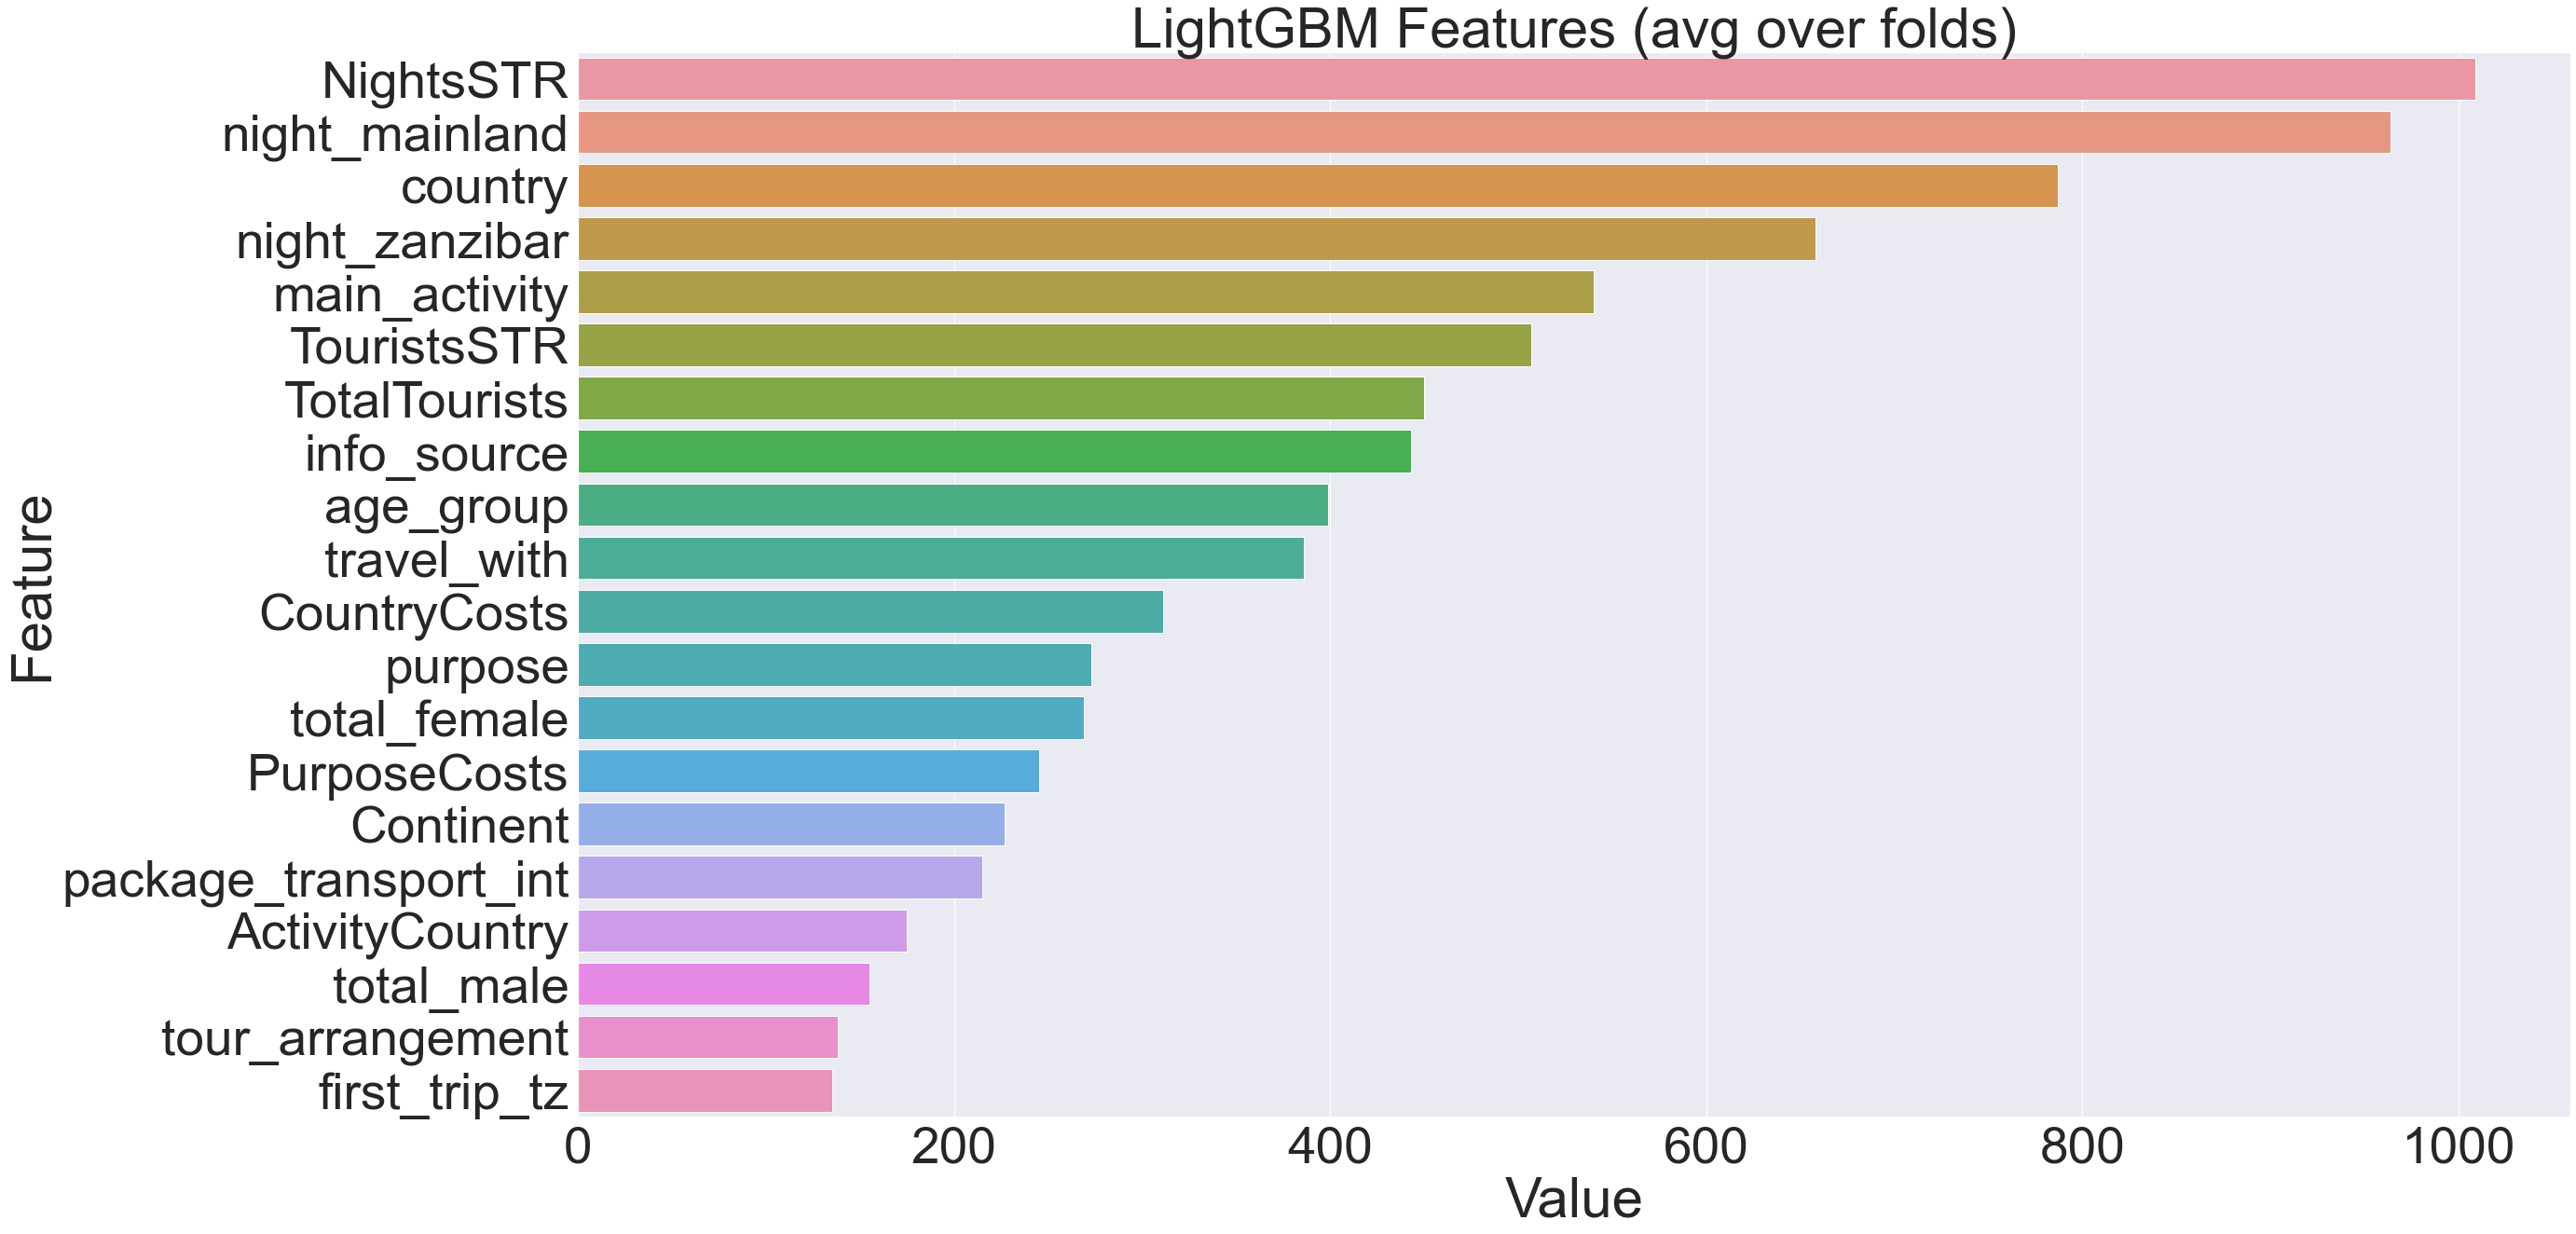

In [139]:
lgbm.fit(X,y)
plotImp(lgbm,X)

## Make the Submission File 

In [140]:
lgbm.fit(X,y)
test_df[['0','1','2','3','4','5']] = lgbm.predict_proba(test_df)
submission = pd.DataFrame({"ID": ID ,"High Cost": test_df['0'],"Higher Cost": test_df['1'],"Highest Cost": test_df['2'],"Low Cost": test_df['3'],"Lower Cost": test_df['4'],"Normal Cost": test_df['5']})
submission.to_csv('Submission.csv',index=False)